# Use CarboScope inversion results to Estimate global xCO2

In [19]:
import datetime
import numpy as np
import xarray as xr
import pandas as pd
import xesmf as xe
import matplotlib.pyplot as plt

In [2]:
cs = xr.open_dataset('/data/artemis/simulations/CarboScope/oc_v2021_paCO2_daily.nc')

In [4]:
print(cs.paCO2)

<xarray.DataArray 'paCO2' (mtime: 23376, lat: 90, lon: 144)>
[302952960 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * mtime    (mtime) datetime64[ns] 1957-01-01T11:59:59 ... 2020-12-31T12:00:00
Attributes:
    units:    uatm


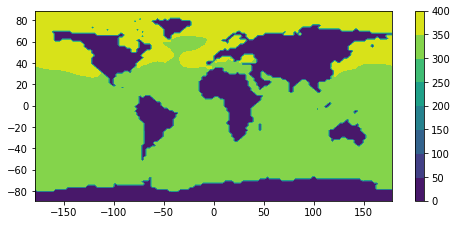

In [8]:
# What does it look like?
fig = plt.figure(figsize=(8,3.5))
plt.contourf(cs.lon,cs.lat,cs.paCO2.mean("mtime"))
plt.colorbar()

In [7]:
# Replace zeros with Nearest Neighbor for regridding:
# First replace zeros with NaN:
atm = cs.paCO2.where(cs.paCO2!=0)
# Then interpolate with nearest neighbor along a latitude band
atm = atm.interpolate_na(dim='lon',method='nearest',limit=None)

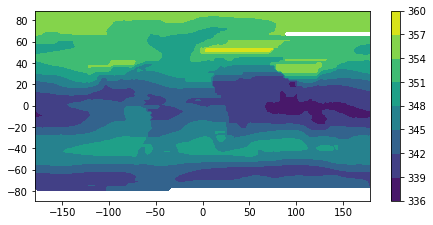

In [10]:
# What does it look like?
fig = plt.figure(figsize=(7.5,3.5))
plt.contourf(atm.lon,atm.lat,atm.mean("mtime"))
plt.colorbar()

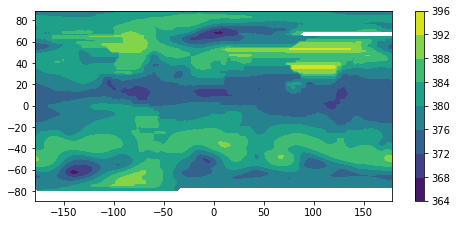

In [11]:
# What does it look like?
fig = plt.figure(figsize=(8,3.5))
plt.contourf(atm.lon,atm.lat,atm[20000,:,:])
plt.colorbar()

In [14]:
# Get monthly means and interpolate onto our grid:
monthly_atm = atm.resample(mtime="1M").mean()

In [30]:
# Interpolate onto SOCAT GRID #####
###################################
socat = xr.open_dataset('/data/artemis/observations/SOCAT/originals/SOCATv2020_tracks_gridded_monthly.nc')
ylat = socat.ylat
xlon = socat.xlon

sgrid = xr.Dataset({'lat':(['lat'],ylat.values),'lon':(['lon'],xlon.values)})
atm_in = xr.Dataset({'atm':(['time','lat','lon'],monthly_atm),'time':(['time'],monthly_atm.mtime),'lat':(['lat'],atm.lat.values),'lon':(['lon'],atm.lon.values)})

regridder = xe.Regridder(atm_in, sgrid, 'bilinear','periodic')

Overwrite existing file: bilinear_90x144_180x360_peri.nc 
 You can set reuse_weights=True to save computing time.


In [31]:
atm_out = regridder(atm_in.atm)

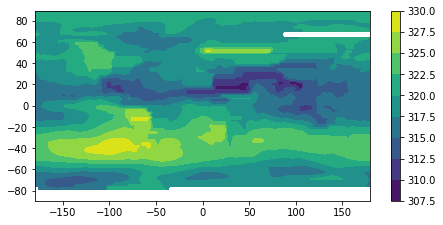

In [32]:
fig = plt.figure(figsize=(7.5,3.5))
plt.contourf(xlon,ylat,atm_out[200,:,:])
plt.colorbar()

In [33]:
# NaNs where land:
fk = xr.open_dataset('/data/artemis/observations/SOCOM/extra_files/FluxKit_calculation_1982-2019_v20201120.nc')
filled_atm = atm_out.where(~np.isnan(fk.area))

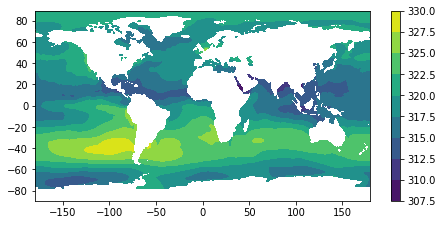

In [34]:
fig = plt.figure(figsize=(7.5,3.5))
plt.contourf(xlon,ylat,filled_atm[200,:,:])
plt.colorbar()

In [25]:
print(atm_out.time)

<xarray.DataArray 'time' (time: 23376)>
array(['1957-01-01T11:59:59.000000000', '1957-01-02T11:59:59.000000000',
       '1957-01-03T11:59:59.000000000', ..., '2020-12-29T12:00:00.000000000',
       '2020-12-30T12:00:00.000000000', '2020-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1957-01-01T11:59:59 ... 2020-12-31T12:00:00


In [36]:
# Get mid-month dates for consistency with other data products:
date_range_start = f'1957-01-01T00:00:00.000000000'
date_range_end = f'2020-12-31T00:00:00.000000000'
# create date vector
dates = pd.date_range(start=date_range_start,end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [37]:
# Write to File
global_pco2_xr = xr.Dataset({
                        'pco2':(["time","lat","lon"],filled_atm)},
                        coords={'time': (['time'],dates),
                               'lat':(['lat'],filled_atm.lat.values),
                               'lon':(['lon'],filled_atm.lon.values)})

global_pco2_xr['pco2'].attrs['units'] = "micro atm"
global_pco2_xr['pco2'].attrs['more info'] = "CarboScope atm pCO2 - 2021 - interpolated to our 1x1 grid and monthly mean"
global_pco2_xr.attrs['description'] = "from /data/artemis/simulations/CarboScope/oc_v2021_paCO2_daily.nc"
global_pco2_xr.attrs['created_by'] = "Val Bennington, CarboScope_atm_pCO2.ipynb"     
global_pco2_xr.to_netcdf("/data/artemis/simulations/CarboScope/CarboScope_global_atm_pco2_1x1_1957-2020.nc")